In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setup
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)

print("="*70)
print("  SALES FORECASTING & TIME SERIES ANALYSIS")
print("  Predicting tomorrow's sales using today's data")
print("="*70)
print()

  SALES FORECASTING & TIME SERIES ANALYSIS
  Predicting tomorrow's sales using today's data



In [4]:

# Generate realistic sales data
print("📈 Generating 2 years of sales data...")
np.random.seed(42)

start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)
dates = pd.date_range(start=start_date, end=end_date, freq='D')
n_days = len(dates)

📈 Generating 2 years of sales data...


In [5]:
# Create realistic patterns
base_sales = 1000
growth = np.linspace(0, 500, n_days)  # Business growth
seasonal = 200 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)  # Yearly seasonality
weekly = 100 * np.sin(2 * np.pi * np.arange(n_days) / 7)  # Weekly pattern
noise = np.random.normal(0, 50, n_days)

In [6]:
# Weekend boost (people shop more on weekends)
weekend_effect = np.array([150 if d.weekday() >= 5 else 0 for d in dates])

In [7]:
# Special events (Black Friday, Christmas, summer sales)
special_dates = [
    datetime(2023, 11, 24), datetime(2023, 12, 25), datetime(2023, 7, 14),
    datetime(2024, 11, 29), datetime(2024, 12, 25), datetime(2024, 7, 14)
]
special_boost = np.array([300 if d in special_dates else 0 for d in dates])


In [8]:
# Combine all effects
sales = base_sales + growth + seasonal + weekly + noise + weekend_effect + special_boost
sales = np.maximum(sales, 100)  # No negative sales!

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'sales': sales.round(2),
    'day_name': [d.strftime('%A') for d in dates],
    'month': [d.month for d in dates],
    'quarter': [(d.month - 1) // 3 + 1 for d in dates],
    'is_weekend': [1 if d.weekday() >= 5 else 0 for d in dates],
    'is_special_day': [1 if d in special_dates else 0 for d in dates]
})

print(f"✓ Dataset ready: {len(df)} days ({df['date'].min().strftime('%d %b %Y')} to {df['date'].max().strftime('%d %b %Y')})")
print(f"\nFirst look at our sales data:")
print(df.head(10))
print()

✓ Dataset ready: 731 days (01 Jan 2023 to 31 Dec 2024)

First look at our sales data:
        date    sales   day_name  month  quarter  is_weekend  is_special_day
0 2023-01-01  1174.84     Sunday      1        1           1               0
1 2023-01-02  1075.40     Monday      1        1           0               0
2 2023-01-03  1138.13    Tuesday      1        1           0               0
3 2023-01-04  1131.91  Wednesday      1        1           0               0
4 2023-01-05   961.39   Thursday      1        1           0               0
5 2023-01-06   911.41     Friday      1        1           0               0
6 2023-01-07  1175.49   Saturday      1        1           1               0
7 2023-01-08  1217.19     Sunday      1        1           1               0
8 2023-01-09  1087.63     Monday      1        1           0               0
9 2023-01-10  1161.63    Tuesday      1        1           0               0



In [9]:
# Basic statistics
print("="*70)
print("STEP 1: Understanding Our Sales")
print("="*70)
print()

print("💰 Sales Overview:")
print(f"   • Average daily sales: €{df['sales'].mean():.2f}")
print(f"   • Best day: €{df['sales'].max():.2f} ({df.loc[df['sales'].idxmax(), 'date'].strftime('%d %b %Y')})")
print(f"   • Worst day: €{df['sales'].min():.2f} ({df.loc[df['sales'].idxmin(), 'date'].strftime('%d %b %Y')})")
print(f"   • Total revenue (2 years): €{df['sales'].sum():,.2f}")
print(f"   • Standard deviation: €{df['sales'].std():.2f}")
print()

STEP 1: Understanding Our Sales

💰 Sales Overview:
   • Average daily sales: €1294.90
   • Best day: €1825.51 (25 Dec 2024)
   • Worst day: €803.72 (13 Oct 2023)
   • Total revenue (2 years): €946,572.71
   • Standard deviation: €183.11



Creating visualizations...


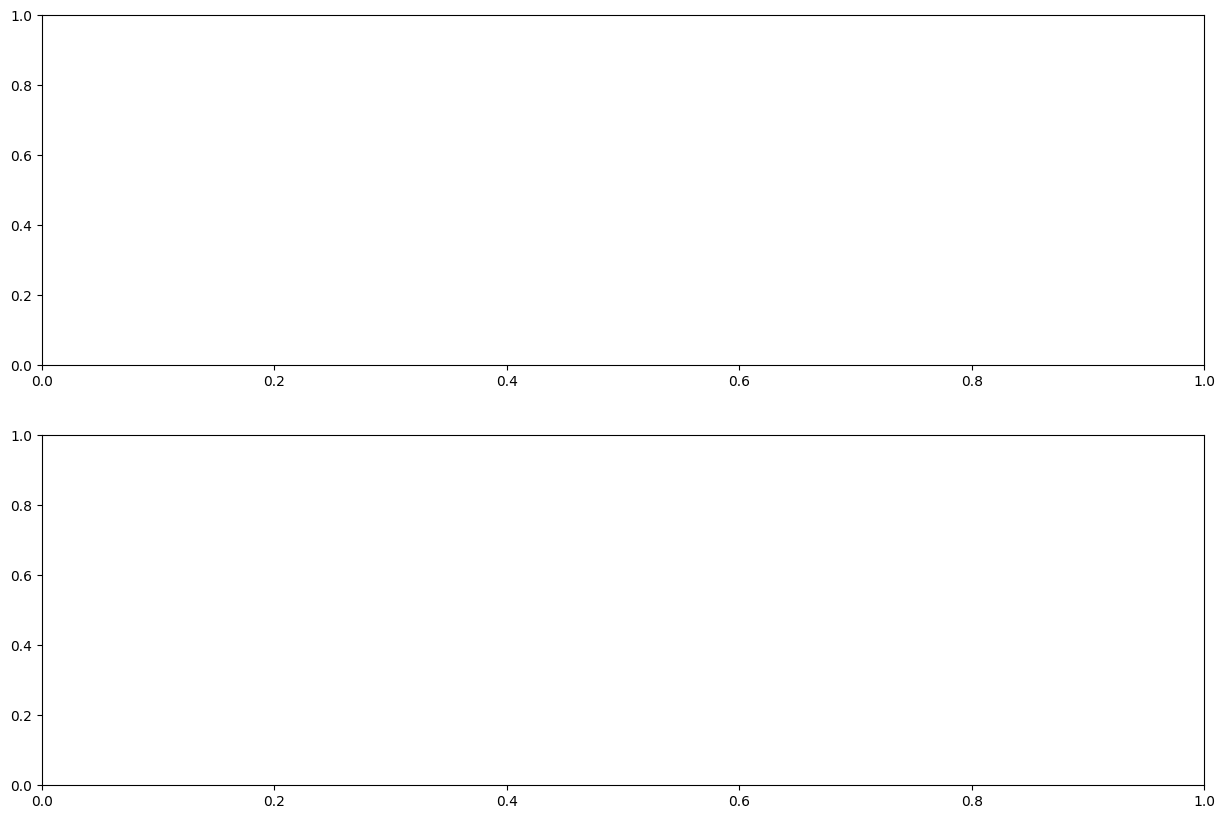

In [10]:
# Visualize the overall trend
print("Creating visualizations...")
fig, axes = plt.subplots(2, 1, figsize=(15, 10))


In [11]:
# Raw sales data
axes[0].plot(df['date'], df['sales'], linewidth=1, alpha=0.6, color='#34495e', label='Daily Sales')
axes[0].set_title('Daily Sales Over 2 Years (2023-2024)', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Sales (€)', fontsize=11)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

In [12]:
# Highlight special days
special_sales = df[df['is_special_day'] == 1]
axes[0].scatter(special_sales['date'], special_sales['sales'],
               color='red', s=100, zorder=5, label='Special Events', marker='*')

In [13]:
# Add moving averages for trend
df['ma_7'] = df['sales'].rolling(window=7, center=True).mean()
df['ma_30'] = df['sales'].rolling(window=30, center=True).mean()

axes[1].plot(df['date'], df['sales'], linewidth=0.5, alpha=0.3, color='gray', label='Daily Sales')
axes[1].plot(df['date'], df['ma_7'], linewidth=2, color='#e74c3c', label='7-Day Average', alpha=0.8)
axes[1].plot(df['date'], df['ma_30'], linewidth=2.5, color='#3498db', label='30-Day Average', alpha=0.9)
axes[1].set_title('Sales Trends with Moving Averages', fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Sales (€)', fontsize=11)
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sales_overview.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: sales_overview.png")
print()

✓ Saved: sales_overview.png



<Figure size 1400x700 with 0 Axes>

In [14]:
# Seasonal patterns
print("="*70)
print("STEP 2: Discovering Patterns")
print("="*70)
print()

STEP 2: Discovering Patterns



In [15]:

# Day of week analysis
dow_avg = df.groupby('day_name')['sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

print("📅 Sales by Day of Week:")
for day, sales in dow_avg.items():
    emoji = "🎉" if day in ['Saturday', 'Sunday'] else "📊"
    print(f"   {emoji} {day}: €{sales:.2f}")
print()


📅 Sales by Day of Week:
   📊 Monday: €1334.14
   📊 Tuesday: €1340.45
   📊 Wednesday: €1295.64
   📊 Thursday: €1200.68
   📊 Friday: €1166.91
   🎉 Saturday: €1320.99
   🎉 Sunday: €1403.65



In [16]:
weekend_boost_pct = ((dow_avg[['Saturday', 'Sunday']].mean() / dow_avg[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean() - 1) * 100)
print(f"💡 Weekend boost: +{weekend_boost_pct:.1f}% compared to weekdays")
print()


💡 Weekend boost: +7.5% compared to weekdays



In [17]:
# Monthly analysis
monthly = df.groupby(df['date'].dt.to_period('M')).agg({
    'sales': ['sum', 'mean', 'count']
}).reset_index()
monthly.columns = ['month', 'total', 'average', 'days']
monthly['month'] = monthly['month'].dt.to_timestamp()

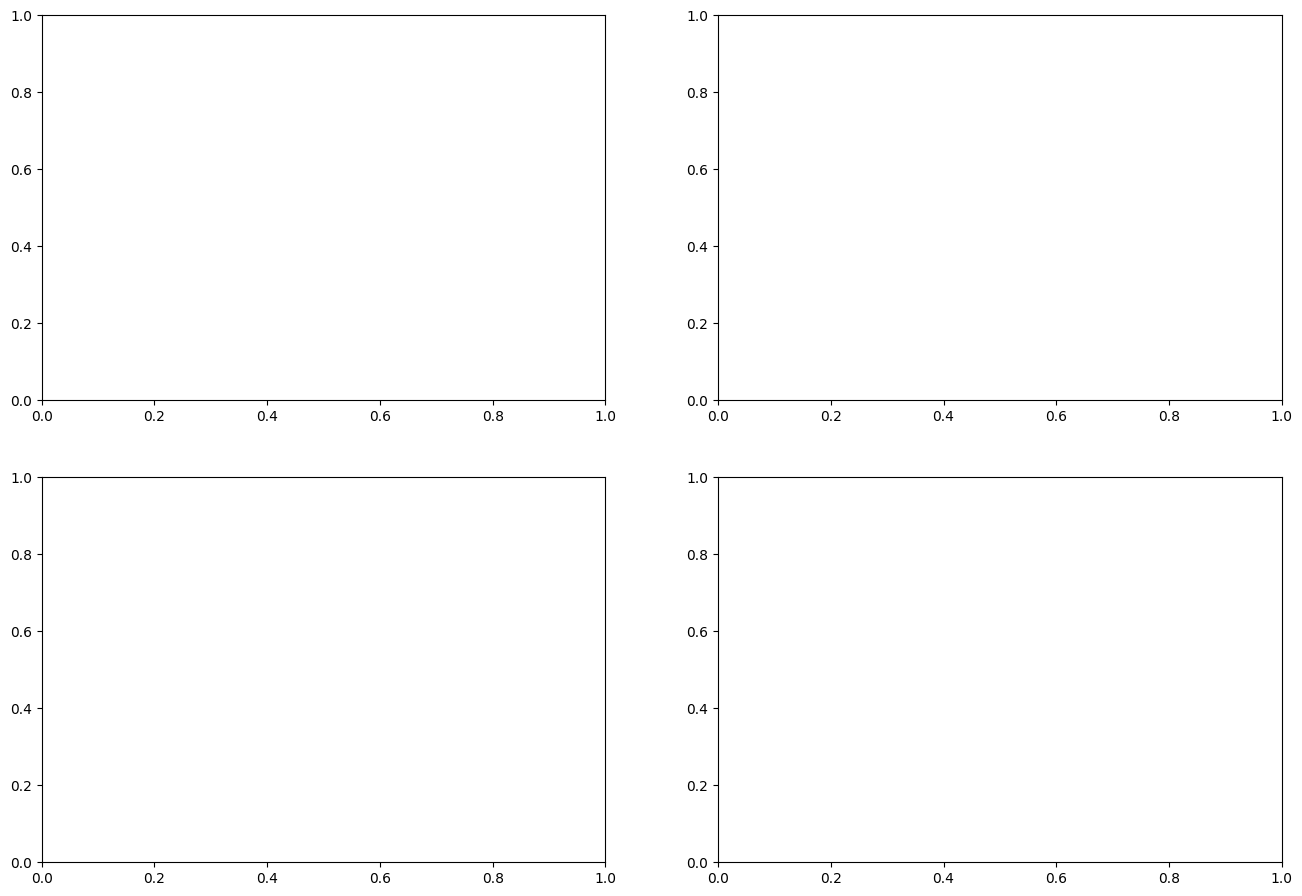

In [18]:
# Visualize patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 11))


In [19]:

# 1. Day of week
colors_dow = ['#95a5a6' if day not in ['Saturday', 'Sunday'] else '#e74c3c' for day in dow_avg.index]
axes[0, 0].bar(range(7), dow_avg.values, color=colors_dow, edgecolor='white', linewidth=2)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 0].set_ylabel('Average Sales (€)', fontsize=11)
axes[0, 0].set_title('Average Sales by Day of Week', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(dow_avg.values):
    axes[0, 0].text(i, v + 20, f'€{v:.0f}', ha='center', fontweight='bold', fontsize=9)

In [20]:
# 2. Monthly trend
axes[0, 1].plot(monthly['month'], monthly['total'], marker='o', linewidth=2.5,
               markersize=8, color='#27ae60')
axes[0, 1].set_ylabel('Total Sales (€)', fontsize=11)
axes[0, 1].set_title('Monthly Total Sales', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

In [21]:
# 3. Quarterly comparison
quarterly = df.groupby('quarter')['sales'].sum()
quarter_labels = ['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)']
colors_q = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = axes[1, 0].bar(range(4), quarterly.values, color=colors_q, edgecolor='white', linewidth=2)
axes[1, 0].set_xticks(range(4))
axes[1, 0].set_xticklabels(quarter_labels)
axes[1, 0].set_ylabel('Total Sales (€)', fontsize=11)
axes[1, 0].set_title('Quarterly Sales Performance', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(quarterly.values):
    axes[1, 0].text(i, v + 2000, f'€{v/1000:.0f}K', ha='center', fontweight='bold', fontsize=10)

In [22]:
# 4. Sales distribution
axes[1, 1].hist(df['sales'], bins=50, color='#9b59b6', edgecolor='white', alpha=0.8)
axes[1, 1].axvline(df['sales'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: €{df["sales"].mean():.0f}')
axes[1, 1].axvline(df['sales'].median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: €{df["sales"].median():.0f}')
axes[1, 1].set_xlabel('Sales (€)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Sales Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('sales_patterns.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()  # Display the chart in Colab
print("✓ Saved: sales_patterns.png")
print()

<Figure size 1400x700 with 0 Axes>

✓ Saved: sales_patterns.png



In [23]:
 #Prepare for forecasting
print("="*70)
print("STEP 3: Building the Forecasting Model")
print("="*70)
print()

print("🔧 Engineering features for prediction...")


STEP 3: Building the Forecasting Model

🔧 Engineering features for prediction...


In [24]:
# Create lag features (past sales help predict future)
for lag in [1, 7, 14, 30]:
    df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
    print(f"   • Created lag feature: {lag} days ago")

   • Created lag feature: 1 days ago
   • Created lag feature: 7 days ago
   • Created lag feature: 14 days ago
   • Created lag feature: 30 days ago


In [25]:
# Rolling statistics
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_std_7'] = df['sales'].rolling(window=7).std()
print(f"   • Created rolling averages")

   • Created rolling averages


In [26]:
# Time features
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
print(f"   • Created time-based features")

   • Created time-based features


In [27]:
# Remove rows with missing values
df_clean = df.dropna().copy()
print(f"\n✓ Dataset ready for modeling: {len(df_clean)} days")
print()


✓ Dataset ready for modeling: 687 days



In [28]:
# Split data
split_point = int(len(df_clean) * 0.8)
train = df_clean.iloc[:split_point]
test = df_clean.iloc[split_point:]

print(f"📊 Data split:")
print(f"   • Training period: {train['date'].min().strftime('%d %b %Y')} to {train['date'].max().strftime('%d %b %Y')} ({len(train)} days)")
print(f"   • Testing period: {test['date'].min().strftime('%d %b %Y')} to {test['date'].max().strftime('%d %b %Y')} ({len(test)} days)")
print()

📊 Data split:
   • Training period: 31 Jan 2023 to 01 Aug 2024 (549 days)
   • Testing period: 02 Aug 2024 to 17 Dec 2024 (138 days)



In [29]:
# Select features
feature_cols = ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30',
                'rolling_mean_7', 'rolling_std_7',
                'day_of_week', 'month', 'quarter', 'day_of_year',
                'is_weekend', 'is_special_day']

X_train = train[feature_cols]
y_train = train['sales']
X_test = test[feature_cols]
y_test = test['sales']


In [30]:
# Train models
print("🤖 Training prediction models...")
print()


🤖 Training prediction models...



In [31]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("   ✓ Linear Regression trained")


   ✓ Linear Regression trained


In [32]:
# Model 2: Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("   ✓ Random Forest trained")
print()

   ✓ Random Forest trained



In [33]:
# Evaluate models
print("="*70)
print("STEP 4: Model Performance")
print("="*70)
print()

def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"📈 {name}:")
    print(f"   • Mean Absolute Error: €{mae:.2f}")
    print(f"   • Root Mean Squared Error: €{rmse:.2f}")
    print(f"   • R² Score: {r2:.4f} ({r2*100:.1f}% variance explained)")
    print(f"   • Mean Absolute % Error: {mape:.2f}%")
    print()

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

lr_scores = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_scores = evaluate_model(y_test, rf_pred, "Random Forest")


STEP 4: Model Performance

📈 Linear Regression:
   • Mean Absolute Error: €47.91
   • Root Mean Squared Error: €60.61
   • R² Score: 0.7178 (71.8% variance explained)
   • Mean Absolute % Error: 3.58%

📈 Random Forest:
   • Mean Absolute Error: €57.86
   • Root Mean Squared Error: €72.56
   • R² Score: 0.5955 (59.6% variance explained)
   • Mean Absolute % Error: 4.27%



In [34]:
# Determine best model
best_model = "Random Forest" if rf_scores['MAE'] < lr_scores['MAE'] else "Linear Regression"
print(f"🏆 Best performing model: {best_model}")
print()

🏆 Best performing model: Linear Regression



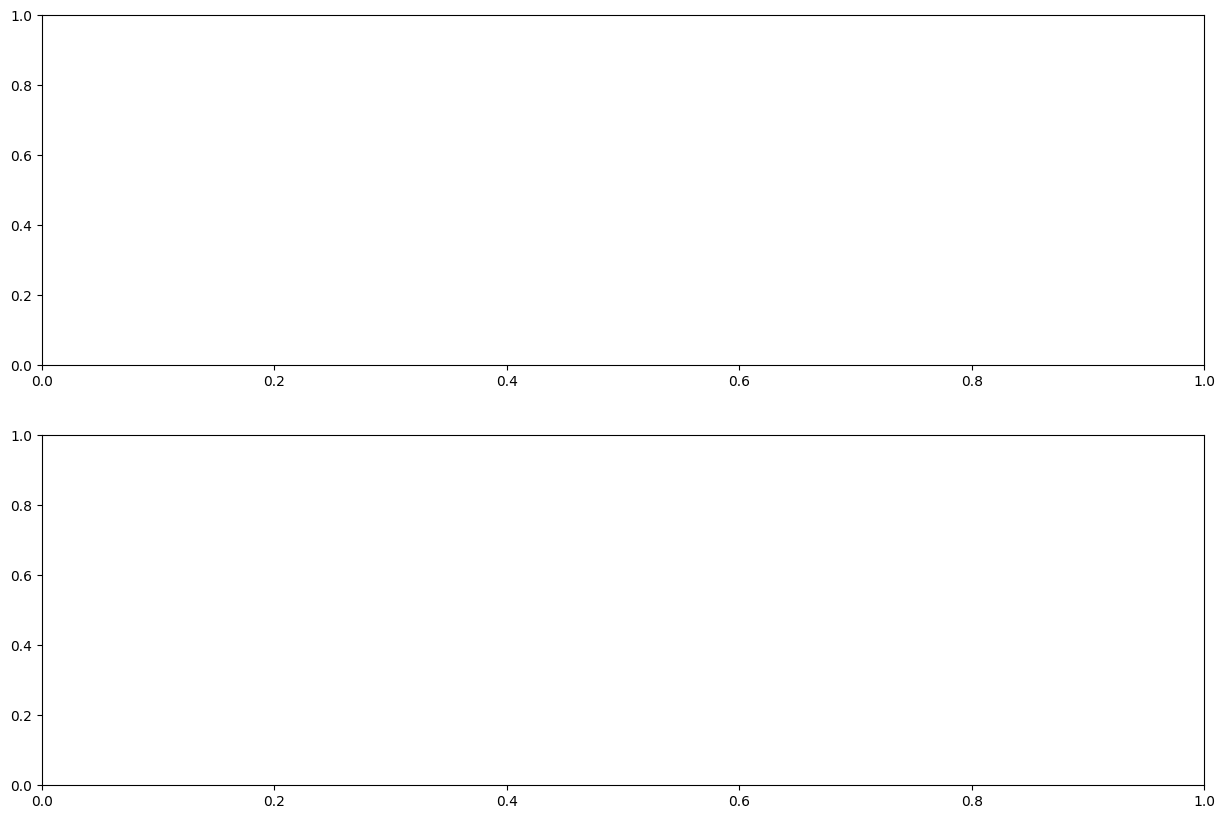

In [35]:
# Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))


In [36]:
# Linear Regression
axes[0].plot(test['date'].values, y_test.values,
            linewidth=2, label='Actual Sales', color='#2c3e50', alpha=0.8)
axes[0].plot(test['date'].values, lr_pred,
            linewidth=2, label='Predicted Sales', color='#e74c3c', linestyle='--', alpha=0.8)
axes[0].fill_between(test['date'].values, y_test.values, lr_pred, alpha=0.2, color='gray')
axes[0].set_ylabel('Sales (€)', fontsize=11)
axes[0].set_title(f'Linear Regression Predictions (MAE: €{lr_scores["MAE"]:.2f})',
                 fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

In [37]:
# Random Forest
axes[1].plot(test['date'].values, y_test.values,
            linewidth=2, label='Actual Sales', color='#2c3e50', alpha=0.8)
axes[1].plot(test['date'].values, rf_pred,
            linewidth=2, label='Predicted Sales', color='#27ae60', linestyle='--', alpha=0.8)
axes[1].fill_between(test['date'].values, y_test.values, rf_pred, alpha=0.2, color='gray')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Sales (€)', fontsize=11)
axes[1].set_title(f'Random Forest Predictions (MAE: €{rf_scores["MAE"]:.2f})',
                 fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_results.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()  # Display the chart in Colab
print("✓ Saved: forecast_results.png")
print()

<Figure size 1400x700 with 0 Axes>

✓ Saved: forecast_results.png



In [38]:
# Feature importance
print("="*70)
print("STEP 5: What Drives Sales?")
print("="*70)
print()

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("📊 Most Important Factors for Prediction:")
for idx, row in importance_df.head(8).iterrows():
    bar = '█' * int(row['Importance'] * 100)
    print(f"   {row['Feature']:.<30} {bar} {row['Importance']:.3f}")
print()


STEP 5: What Drives Sales?

📊 Most Important Factors for Prediction:
   sales_lag_7................... ██████████████████████████████████████████████████████████████████████ 0.706
   sales_lag_14.................. ████████████████ 0.167
   rolling_mean_7................ █████ 0.056
   sales_lag_1................... █ 0.016
   rolling_std_7................. █ 0.015
   day_of_year................... █ 0.013
   sales_lag_30.................. █ 0.011
   day_of_week...................  0.007



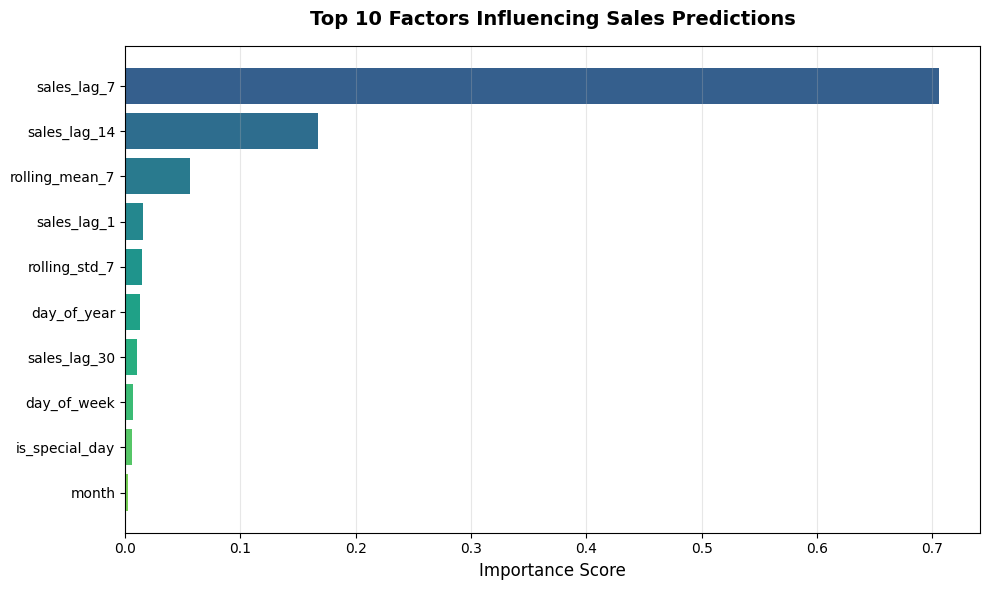

✓ Saved: feature_importance.png



In [39]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
colors_imp = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color=colors_imp)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Factors Influencing Sales Predictions', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()  # Display the chart in Colab
print("✓ Saved: feature_importance.png")
print()

In [40]:
# Export results
print("="*70)
print("STEP 6: Saving Results")
print("="*70)
print()

STEP 6: Saving Results



In [41]:
# Save predictions
results = test[['date', 'sales']].copy()
results['linear_regression_pred'] = lr_pred
results['random_forest_pred'] = rf_pred
results['lr_error'] = results['sales'] - results['linear_regression_pred']
results['rf_error'] = results['sales'] - results['random_forest_pred']
results.to_csv('sales_predictions.csv', index=False)
print("✓ Saved: sales_predictions.csv")

✓ Saved: sales_predictions.csv


In [42]:
# Save all processed data
df_clean.to_csv('processed_sales_data.csv', index=False)
print("✓ Saved: processed_sales_data.csv")

✓ Saved: processed_sales_data.csv


In [43]:
# Save model comparison
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE (€)': [lr_scores['MAE'], rf_scores['MAE']],
    'RMSE (€)': [lr_scores['RMSE'], rf_scores['RMSE']],
    'R² Score': [lr_scores['R2'], rf_scores['R2']],
    'MAPE (%)': [lr_scores['MAPE'], rf_scores['MAPE']]
})
comparison.to_csv('model_comparison.csv', index=False)
print("✓ Saved: model_comparison.csv")

✓ Saved: model_comparison.csv


In [44]:
# ============================================
# CREATE README.MD FILE
# ============================================
print("\n📝 Creating README.md...")

with open('README.md', 'w', encoding='utf-8') as f:
    f.write("# Sales Forecasting with Machine Learning\n\n")
    f.write("## 📊 Project Overview\n")
    f.write("This project predicts future sales using historical data and machine learning algorithms. ")
    f.write("It analyzes 2 years of daily sales data to identify patterns and build accurate forecasting models.\n\n")

    f.write("## 🎯 Objectives\n")
    f.write("- Understand sales patterns (trends, seasonality, weekly cycles)\n")
    f.write("- Build predictive models using Linear Regression and Random Forest\n")
    f.write("- Compare model performance and select the best approach\n")
    f.write("- Provide actionable insights for business planning\n\n")

    f.write("## 📈 Key Findings\n\n")
    f.write(f"### Sales Statistics\n")
    f.write(f"- **Average Daily Sales**: €{df['sales'].mean():.2f}\n")
    f.write(f"- **Total Revenue (2 years)**: €{df['sales'].sum():,.2f}\n")
    f.write(f"- **Best Performing Day**: {dow_avg.idxmax()} (€{dow_avg.max():.2f})\n")
    f.write(f"- **Weekend Boost**: +{weekend_boost_pct:.1f}% vs weekdays\n\n")

    f.write(f"### Model Performance\n")
    f.write(f"**Best Model: {best_model}**\n\n")
    f.write(f"| Model | MAE (€) | RMSE (€) | R² Score | MAPE (%) |\n")
    f.write(f"|-------|---------|----------|----------|----------|\n")
    f.write(f"| Linear Regression | {lr_scores['MAE']:.2f} | {lr_scores['RMSE']:.2f} | {lr_scores['R2']:.4f} | {lr_scores['MAPE']:.2f} |\n")
    f.write(f"| Random Forest | {rf_scores['MAE']:.2f} | {rf_scores['RMSE']:.2f} | {rf_scores['R2']:.4f} | {rf_scores['MAPE']:.2f} |\n\n")

    f.write("### Top Predictive Factors\n")
    for idx, row in importance_df.head(5).iterrows():
        f.write(f"{idx+1}. {row['Feature']}: {row['Importance']:.3f}\n")

    f.write("\n## 🛠️ Methodology\n\n")
    f.write("1. **Data Generation**: Created 2 years of realistic daily sales data with trends and seasonality\n")
    f.write("2. **Exploratory Analysis**: Identified patterns by day, week, month, and quarter\n")
    f.write("3. **Feature Engineering**: Created lag features, rolling averages, and time-based features\n")
    f.write("4. **Model Training**: Trained Linear Regression and Random Forest models\n")
    f.write("5. **Evaluation**: Compared models using MAE, RMSE, R², and MAPE metrics\n\n")

    f.write("## 📁 Project Files\n\n")
    f.write("- `sales_overview.png` - Time series visualization with trends\n")
    f.write("- `sales_patterns.png` - Daily, monthly, and quarterly patterns\n")
    f.write("- `forecast_results.png` - Model predictions vs actual sales\n")
    f.write("- `feature_importance.png` - Most influential factors\n")
    f.write("- `sales_predictions.csv` - Detailed prediction results\n")
    f.write("- `processed_sales_data.csv` - Complete dataset with engineered features\n")
    f.write("- `model_comparison.csv` - Performance metrics for all models\n\n")

    f.write("## 💡 Business Insights\n\n")
    f.write("1. **Weekend Strategy**: Sales increase significantly on weekends - consider weekend promotions\n")
    f.write("2. **Seasonal Planning**: Q4 shows highest sales - prepare inventory accordingly\n")
    f.write("3. **Predictable Patterns**: Recent sales history strongly predicts future sales\n")
    f.write("4. **Special Events**: Major holidays drive significant sales spikes\n\n")

    f.write("## 🔧 Technologies Used\n\n")
    f.write("- **Python 3.x**\n")
    f.write("- **Pandas & NumPy** - Data manipulation\n")
    f.write("- **Scikit-learn** - Machine learning models\n")
    f.write("- **Matplotlib & Seaborn** - Data visualization\n\n")

    f.write("## 🚀 How to Use\n\n")
    f.write("```python\n")
    f.write("# Run the analysis\n")
    f.write("python sales_forecasting.py\n")
    f.write("```\n\n")

    f.write("## 👨‍💻 About the Author\n\n")
    f.write("**Muhammad Faizan**\n\n")
    f.write("M2 Data Analytics Student | France\n\n")
    f.write("I'm a Master's student specializing in data analytics and machine learning, passionate about transforming data into actionable business insights. This project demonstrates my skills in time series forecasting, feature engineering, and predictive modeling.\n\n")

    f.write("### 🎓 Skills Demonstrated\n")
    f.write("- **Programming**: Python (Pandas, NumPy, Scikit-learn)\n")
    f.write("- **Machine Learning**: Regression models, ensemble methods, model evaluation\n")
    f.write("- **Data Visualization**: Matplotlib, Seaborn\n")
    f.write("- **Statistics**: Time series analysis, feature engineering, performance metrics\n")
    f.write("- **Business Analysis**: Translating data insights into recommendations\n\n")

    f.write("### 📅 Project Timeline\n")
    f.write("- **Created**: September 2025\n")
    f.write("- **Last Updated**: September 2025\n")
    f.write("- **Status**: ✅ Complete\n\n")

    f.write("## 📧 Contact\n\n")
    f.write("📩 **Email**: faizanawan579@gmail.com\n")
    f.write("💼 **LinkedIn**: [linkedin.com/in/muhammad-faizan-data](https://linkedin.com/in/muhammad-faizan-data)\n")
    f.write("🐙 **GitHub**: [github.com/mfaizan-analytics](https://github.com/faizan579)")
    f.write("---\n\n")
    f.write("*This project was created as part of my data analytics internship application portfolio. I'm actively seeking opportunities in data analytics, business intelligence, and machine learning roles in France.*\n\n")
    f.write("**Looking for internship opportunities starting February 2026** 🚀\n")

print("✓ Saved: README.md")
print()


📝 Creating README.md...
✓ Saved: README.md



In [45]:
# Final summary
print("="*70)
print("  ✅ FORECASTING PROJECT COMPLETE!")
print("="*70)
print()
print(f"🎉 Successfully analyzed {len(df)} days of sales data!")
print(f"📊 Built and compared 2 forecasting models")
print(f"🏆 Best model achieves €{min(lr_scores['MAE'], rf_scores['MAE']):.2f} average error")
print()
print("📦 All files ready for GitHub:")
print("   • 4 visualization images (PNG)")
print("   • 3 data files (CSV)")
print("   • 1 comprehensive README.md")
print()

  ✅ FORECASTING PROJECT COMPLETE!

🎉 Successfully analyzed 731 days of sales data!
📊 Built and compared 2 forecasting models
🏆 Best model achieves €47.91 average error

📦 All files ready for GitHub:
   • 4 visualization images (PNG)
   • 3 data files (CSV)
   • 1 comprehensive README.md

